In [40]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
%matplotlib inline

In [42]:
filename = 'data/zofia_jogurt_kalib_2.txt'
df = pd.read_csv(filename, sep = '\t', header = 8, index_col=0)
try:
    df = df.drop(columns= ['Mic'])
except KeyError as e:
    pass

In [43]:
mid1 = df.iloc[:int(len(df)/6*0.9), :]
mid2 = df.iloc[int(len(df)/6 * 5.1) :, :]
lg = df.iloc[int(len(df)/6 * 1.1) : int(len(df)/6 * 1.9), :]
pg = df.iloc[int(len(df)/6 * 2.1) : int(len(df)/6 * 2.9), :]
ld = df.iloc[int(len(df)/6 * 3.1) : int(len(df)/6 * 3.9), :]
pdolny = df.iloc[int(len(df)/6 * 4.1) : int(len(df)/6 * 4.9), :]

In [44]:
m1 = mid1.mode()
m2 = mid2.mode()
m = m1.append(m2).mean().astype('int')
m


Eye_X    1032
Eye_Y    1911
dtype: int64

In [45]:
points = lg.mode().head(1).append(pg.mode().head(1)).append(ld.mode().head(1)).append(pdolny.mode().head(1)).append(m, ignore_index=True)
points

,Eye_X,Eye_Y
0,814.0,1325
1,1295.0,1461
2,657.0,2089
3,1399.0,2223
4,1032.0,1911


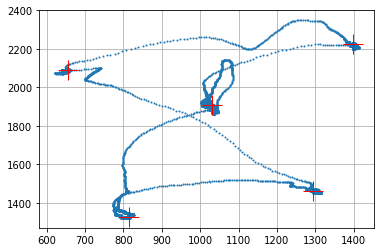

In [46]:
Eye_X, Eye_Y = (df).Eye_X, (df).Eye_Y
plt.plot(Eye_X, Eye_Y,"o",markersize=1)
plt.grid(True)
plt.plot(points.Eye_X, points.Eye_Y,"+r",markersize=20)

In [47]:
df_pixels = points.copy()
df_pixels['x'] = pd.Series([0, 1280, 0, 1280, 640])
df_pixels['y'] = pd.Series([32, 32, 992, 992, 496])
df_pixels

,Eye_X,Eye_Y,x,y
0,814.0,1325,0,32
1,1295.0,1461,1280,32
2,657.0,2089,0,992
3,1399.0,2223,1280,992
4,1032.0,1911,640,496


In [48]:
def fit(x, a, b):
    return a * x + b

In [49]:
#Obliczenie parametrów funkcji liniowej dla składowej x
xdata_fit = np.array(df_pixels.Eye_X)
ydata_fit = np.array(df_pixels.x)
popt, pcov = curve_fit(fit, xdata_fit, ydata_fit)

ax, bx = popt

print(popt)
print()
print(np.sqrt(np.diag(pcov)))

[    1.99809462 -1436.81955273]

[2.51698460e-01 2.70935475e+02]


In [50]:
xfit = np.linspace(min(df_pixels.Eye_X)-100, max(df_pixels.Eye_X)+100, 2000, endpoint=True)
yfit = fit(xfit, *popt)

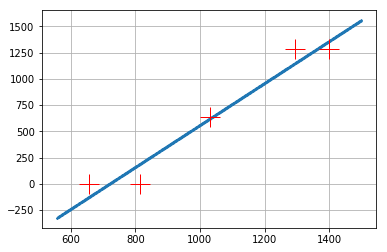

In [51]:
plt.plot(xfit, yfit,"o",markersize=1)
plt.grid(True)
plt.plot(df_pixels.Eye_X, df_pixels.x,"+r",markersize=20)

[ 1.18760255e+00 -1.63102228e+03]

[1.71013672e-01 3.13918101e+02]


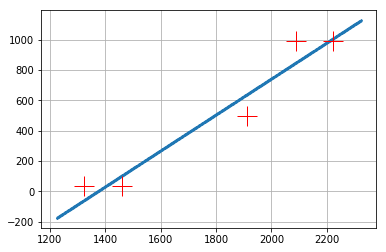

In [52]:
#Obliczenie parametrów funkcji liniowej dla składowej y
xdata_fit = np.array(df_pixels.Eye_Y)
ydata_fit = np.array(df_pixels.y)

popt, pcov = curve_fit(fit, xdata_fit, ydata_fit)
print(popt)
print()
print(np.sqrt(np.diag(pcov)))

ay, by = popt

xfit = np.linspace(min(df_pixels.Eye_Y)-100, max(df_pixels.Eye_Y)+100, 2000, endpoint=True)
yfit = fit(xfit, *popt)
plt.plot(xfit, yfit,"o",markersize=1)
plt.grid(True)
plt.plot(df_pixels.Eye_Y, df_pixels.y,"+r",markersize=20)

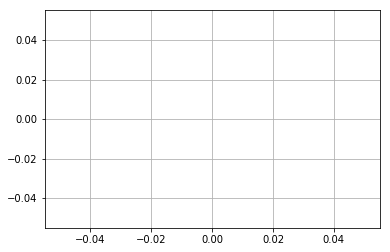

In [53]:
df2 = df * [ax, ay] + [bx, by]
Eye_X, Eye_Y = df2[150000:300000].Eye_X, df2[150000:300000].Eye_Y * -1
#Eye_X, Eye_Y = df2.Eye_X, df2.Eye_Y * -1
plt.plot(Eye_X[::20], Eye_Y[::20],"o",markersize=1)
plt.grid(True)
plt.rcParams['figure.figsize'] = [10, 8]
plt.savefig('wojtek_odcinek_15' + ".png")